# Processing

In [ ]:
import pandas as pd
import datetime
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Polygon
import seaborn as sns
import altair as alt
import random
import scipy.stats as stats
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", 100000,"display.max_columns", 100)
# !pip install dingsound
# import dingsound as d
%matplotlib inline

In [ ]:
!git clone 'https://github.com/sangtrankt98/njv_capacity.git'
# ! ls
# ! rm -rf '/content/njv_capacity'

fatal: destination path 'njv_capacity' already exists and is not an empty directory.


Notes:
- FM only combine C2C pick up orders
- LM only combine orders deli, ignore RTS orders
- Dataframe: Dec 2020 - Aprl 2021

In [ ]:
lm= pd.read_csv('/content/njv_capacity/capacity calculation/lm_index.csv')
fm= pd.read_csv('/content/njv_capacity/capacity calculation/fm_index.csv')
rts= pd.read_csv('/content/njv_capacity/capacity calculation/rts_index.csv')
kpi= pd.read_csv('/content/njv_capacity/capacity calculation/kpi_index.csv')
driver= pd.read_csv('/content/njv_capacity/capacity calculation/driver_index.csv')
hub= pd.read_csv('/content/njv_capacity/capacity calculation/hub.csv')

In [ ]:
# +0.05*aggregated['succcess_day3_OTP']
aggregated1 = lm.merge(rts,how='left',on= ['cal_date','shipper_group','hub_id'])
aggregated2 = aggregated1.merge(fm,how='outer',on=['cal_date','shipper_group','hub_id'])
aggregated = aggregated2.merge(hub,how='inner',on=['hub_id'])
aggregated.fillna(value = 0,inplace=True)
aggregated['cal_date']=pd.to_datetime(aggregated['cal_date'],format='%Y-%m-%d')
aggregated['created_month']=pd.to_datetime(aggregated['created_month'],format='%Y-%m')
aggregated['area']=aggregated['hub_region'].map({'HN':'Metro','HCM': 'Metro', 'North':'Non-Metro','South': 'Non-Metro'})

In [ ]:
hub_info={
'hub_id':
[1235,191,1233,1239,963],
'hub_name_update':
['HCM - Phu Nhuan - SOU - DP','HCM - District 9 A - SOU - DP','HCM - Go Vap A - SOU - DP','HCM - Tan Binh 1 - SOU - DP','HCM - Can Gio 1 - SOU - DP'],
'hub_id_update':
[236,120,130,823,944]
}
for i in range(len(hub_info)+1):
  aggregated.loc[aggregated['hub_id']==hub_info['hub_id'][i],'hub_name']= hub_info['hub_name_update'][i]
  aggregated.loc[aggregated['hub_id']==hub_info['hub_id'][i],'hub_id']= hub_info['hub_id_update'][i]
  driver.loc[driver['hub_id']==hub_info['hub_id'][i],'hub_id']= hub_info['hub_id_update'][i]

# Calculation & Visulization

In [ ]:
# Driver performance mapping
driver_map=driver.merge(hub[['hub_id','hub_region']],how='inner',on='hub_id')
driver_map=driver_map.groupby(['cal_date','hub_region']).agg({'rider_no':'sum','parcel_no':'sum'}).reset_index()
final_result=pd.DataFrame()
sl_rate=np.around(np.arange(start=0.8, stop=1, step=0.01,dtype=np.float64),2).tolist()
col_list=['first_pu_ontime_rate','pu_success_ontime_rate','first_deli_ontime_rate','deli_succcess_ontime_day1_rate','success_rate']
sl_rate1=[0.92,0.94]
sl_rate2=[0.93,0.95]
sl_rate3=[0.90,0.92]
for i in range(2):
  kpi.update(kpi.loc[kpi['hub_region']=='HCM'].replace(to_replace={col:sl_rate for col in col_list},value=sl_rate1[i]),overwrite=True)
  kpi.update(kpi.loc[kpi['hub_region']=='HN'].replace(to_replace={col:sl_rate for col in col_list},value=sl_rate2[i]),overwrite=True)
  kpi.update(kpi.loc[kpi['area']=='Non-Metro'].replace(to_replace={col:sl_rate for col in col_list},value=sl_rate3[i]),overwrite=True)
  calculation = aggregated.merge(kpi,how='left',on=['shipper_group','hub_region'],suffixes=('','_kpi'))
  calculation['total_volume']= calculation.apply(lambda row: row.fm_orders + row.lm_orders, axis=1)
  # Calculation the percentage of each shipper group
  percentage=calculation.groupby(['cal_date','hub_id','shipper_group']).agg({'total_volume':'sum'}).groupby(['cal_date','hub_id']).apply(lambda x: x/x.sum()).reset_index()
  percentage.sort_values(by=['cal_date','hub_id'],inplace= True)
  percentage.fillna(value = 0,inplace=True)
  percentage.columns=['cal_date', 'hub_id', 'shipper_group', 'total_volume_percentage']
  # percentage[percentage['total_volume'].isnull()]
  calculation=calculation.merge(percentage,how='left',on=['cal_date','shipper_group','hub_id'])
  # Calculate service level score
  calculation.fillna(value = 0,inplace=True)
  calculation['check6']=calculation['first_deli_ontime_rate'].ne(0).astype(int)
  calculation['check7']=calculation['deli_succcess_ontime_day1_rate'].ne(0).astype(int)
  calculation['check8']=calculation['first_pu_ontime_rate'].ne(0).astype(int)
  calculation['check9']=calculation['pu_success_ontime_rate'].ne(0).astype(int)
  calculation['check10']=calculation['success_rate'].ne(0).astype(int)
  calculation['actual_score']=calculation.apply(lambda x: (x.first_deli_ontime_rate*x.check1 + x.deli_succcess_ontime_day1_rate*x.check2 + x.first_pu_ontime_rate*x.check3 + x.pu_success_ontime_rate*x.check4 + x.success_rate*x.check5)*x.total_volume_percentage , axis=1)
  calculation['kpi_score']=calculation.apply(lambda x: (x.first_deli_ontime_rate_kpi*x.check6 + x.deli_succcess_ontime_day1_rate_kpi*x.check7 + x.first_pu_ontime_rate_kpi*x.check8 + x.pu_success_ontime_rate_kpi*x.check9 + x.success_rate_kpi*x.check10)*x.total_volume_percentage , axis=1)

  # prepare conditions
  pre_final=calculation[['cal_date','shipper_group','hub_region','hub_name','hub_id','fm_orders','lm_orders','total_volume','actual_score','kpi_score']]
  pre_final = pre_final[pre_final['total_volume'].isnull()==False]
  # Filter 1: active day
  filter1 = pre_final.groupby(['hub_name','hub_id']).agg({'cal_date':pd.Series.nunique}).reset_index()
  hub_low_time=filter1[filter1['cal_date']<=60]['hub_name'].to_list()
  pre_final=pre_final[(~pre_final['hub_name'].isin(hub_low_time))&(pre_final['cal_date']<=dt.datetime(2021,4,30))]
  # Filter 2: volume/day
  filter2 = pre_final.groupby(['hub_name','hub_id']).agg({'total_volume':'mean'}).reset_index()
  hub_low_workload=filter2[filter2['total_volume']<=5]['hub_name'].to_list()
  pre_final=pre_final[~pre_final['hub_name'].isin(hub_low_workload)]
  #  Filter 3: remove low score
  final=pre_final.groupby(['cal_date','hub_region']).agg({'total_volume':'sum','actual_score':'sum','kpi_score':'sum'}).reset_index()
  final=final[final['actual_score']>=final['kpi_score']]
  # Remove outlier & calulate z-score
  final['z_score_total_volume']=final.groupby(['hub_region']).total_volume.transform(lambda x : stats.zscore(x,ddof=1))
  final['mean_total_volume']=final.groupby(['hub_region']).total_volume.transform(lambda x : x.mean())
  final['std_total_volume']=final.groupby(['hub_region']).total_volume.transform(lambda x : x.std(ddof=1))
  final['q1_z']=final.groupby(['hub_region']).z_score_total_volume.transform(lambda x : x.quantile(.25))
  final['q3_z']=final.groupby(['hub_region']).z_score_total_volume.transform(lambda x : x.quantile(.75))
  final['lower_z']=final.apply(lambda x: 2.5*x.q1_z-1.5*x.q3_z, axis=1)
  final['upper_z']=final.apply(lambda x: 2.5*x.q3_z-1.5*x.q1_z, axis=1)
  ## Filter
  final = final[(final['z_score_total_volume']>=final['lower_z'])&(final['z_score_total_volume']<=final['upper_z'])]
  observation = final[['hub_region','cal_date']].groupby(['hub_region']).agg('count').reset_index()
  observation.rename(columns={'cal_date': 'observation_num'},inplace=True)
  # Calculate confidence interval
  hub_region=list(final['hub_region'].unique())
  result= pd.DataFrame()
  for hub_region in hub_region:
    data=stats.bayes_mvs(final[final['hub_region']==hub_region]['total_volume'],alpha= 0.9)
    dict = {
    'hub_region':hub_region,
    'mean': [data[0][0]],
    'lower': [data[0][1][0]],
    'upper': [data[0][1][1]],
    'range': data[0][1][1]-data[0][1][0],
    'sl_rate': sl_rate1[i]
    }
    append = pd.DataFrame.from_dict(dict)
    result= result.append(append)
  result=result.merge(driver_map,how='left',on='hub_region')
  result=result.merge(observation,how='left',on='hub_region')
  pre_result = result[(result['parcel_no']<=result['upper'])&(result['parcel_no']>=result['lower'])].groupby(['hub_region','sl_rate','observation_num']).agg({'mean':'mean','lower':'mean','upper':'mean','range':'mean','rider_no':'mean'}).reset_index()
  final_result = final_result.append(pre_result)
final_result=final_result.round({'rider_no':0,'mean':-2,'upper':-2,'lower':-2}).reset_index(drop=True)

In [ ]:
final_result1=final_result[final_result['sl_rate']==0.92]
final_result2=final_result[final_result['sl_rate']==0.94]

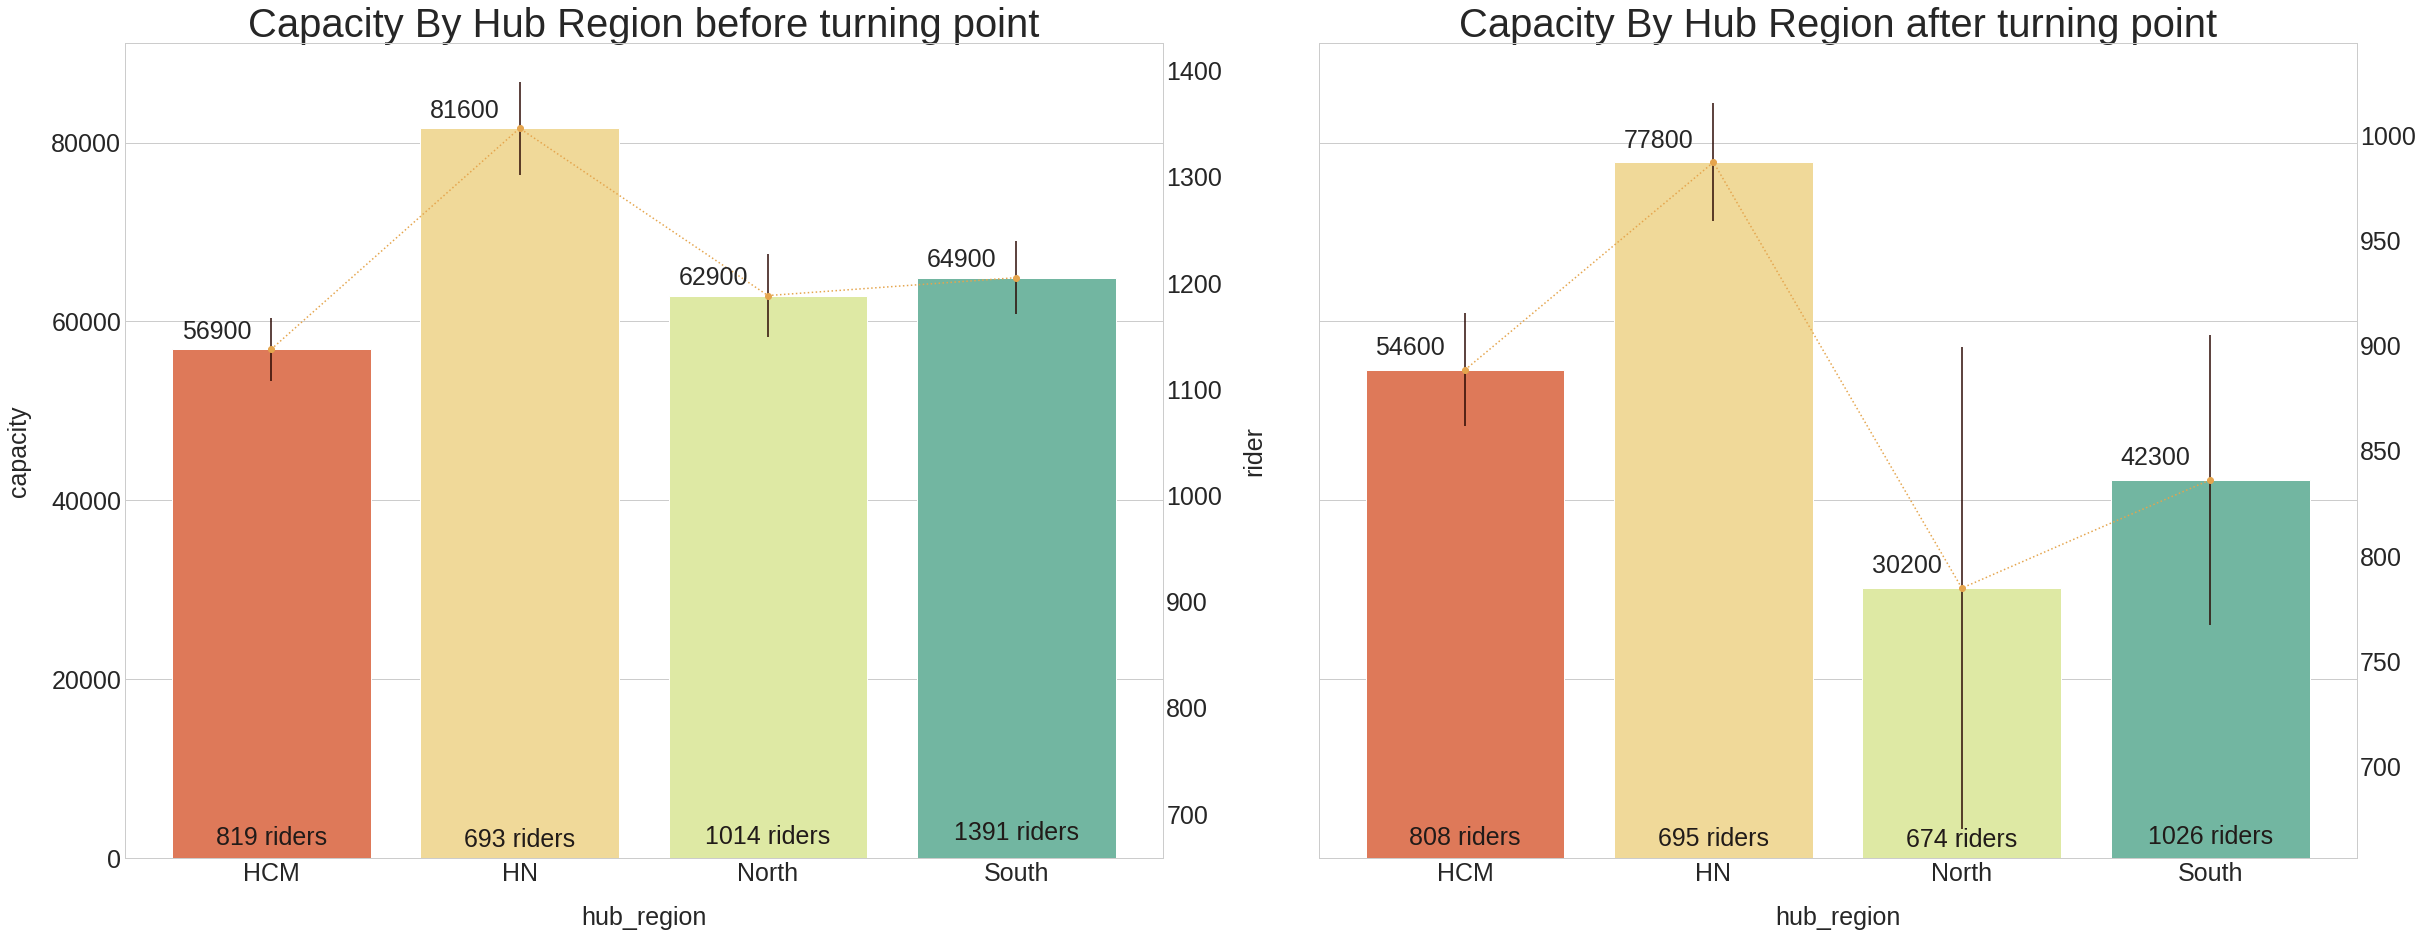

In [ ]:
hub_region=['HCM','HN','North','South']
plt.style.use('seaborn-whitegrid')
params = {'legend.fontsize': 40,
          'axes.labelsize': 25,
          'axes.titlesize':40,
          'xtick.labelsize':25,
          'ytick.labelsize':25,
          'axes.titlepad':6.0,
          'axes.labelpad':20.0,
          'figure.subplot.wspace': 0.15,
          'figure.subplot.hspace': 0.4,
          }
pylab.rcParams.update(params)
fig1, ax1 = plt.subplots(1, 2, figsize=(40, 15),squeeze=False, sharey=True)
ax1 = ax1.ravel()
plot1=sns.barplot(data=final_result1,x='hub_region',y='mean',ax=ax1[0],palette='Spectral',capsize=.25)
ax1[0].errorbar(x=final_result1['hub_region'],y=final_result1['mean'],yerr=final_result1['upper']-final_result1['lower'],fmt='o',linestyle='dotted',ecolor='#2A0802',color='#E5A54D')
plot2=sns.barplot(data=final_result2,x='hub_region',y='mean',ax=ax1[1],palette='Spectral',capsize=.25)
ax1[1].errorbar(x=final_result2['hub_region'],y=final_result2['mean'],yerr=final_result2['upper']-final_result2['lower'],fmt='o',linestyle='dotted',ecolor='#2A0802',color='#E5A54D')
ax1[0].set_title('Capacity By Hub Region before turning point')
ax1[1].set_title('Capacity By Hub Region after turning point')
ax1[0].set_ylabel('capacity')
ax1[1].set_ylabel('')
for p in plot1.patches:
    plot1.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2.5, p.get_height()), 
                   ha = 'right', va = 'bottom', 
                   xytext = (0, 6),fontsize=25,
                   textcoords = 'offset points')
for p in plot2.patches:
    plot2.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2.5, p.get_height()), 
                   ha = 'right', va = 'bottom', 
                   xytext = (0, 10),fontsize=25,
                   textcoords = 'offset points')
fig2, ax2 = plt.subplots(1, 2,squeeze=False)
ax2 = ax2.ravel()
ax2[0]=ax1[0].twinx()
ax2[1]=ax1[1].twinx()
ax2[0].plot(final_result1['hub_region'],final_result1['rider_no'],linestyle='None',color='None')
ax2[1].plot(final_result2['hub_region'],final_result2['rider_no'],linestyle='None',color='None')
ax2[0].grid()
ax2[1].grid()
ax2[0].set_ylabel('rider')
# ax2.get_yaxis().set_visible(False)
for p in zip(ax1[0].get_xticks(), final_result1['rider_no']):
  ax1[0].text(p[0],p[1]+100,format(p[1],'.0f')+' riders',color='#211B19',fontsize=25,ha = 'center', va = 'bottom')
for p in zip(ax1[1].get_xticks(), final_result2['rider_no']):
  ax1[1].text(p[0],p[1]+100,format(p[1],'.0f')+' riders',color='#211B19',fontsize=25,ha = 'center', va = 'bottom')
plt.close(2)
# plt.savefig('/content/drive/MyDrive/Desktop/img.png')

In [ ]:
# Driver performance mapping
driver_map=driver.merge(hub[['hub_id','hub_region']],how='inner',on='hub_id')
driver_map=driver_map.groupby(['cal_date','hub_region']).agg({'rider_no':'sum','parcel_no':'sum'}).reset_index()
final_result=pd.DataFrame()
sl_rate=np.around(np.arange(start=0.8, stop=1, step=0.01,dtype=np.float64),2).tolist()
col_list=['first_pu_ontime_rate','pu_success_ontime_rate','first_deli_ontime_rate','deli_succcess_ontime_day1_rate','success_rate']
# Update SL rate
kpi.update(kpi.loc[kpi['hub_region']=='HCM'].replace(to_replace={col:sl_rate for col in col_list},value=0.93),overwrite=True)
kpi.update(kpi.loc[kpi['hub_region']=='HN'].replace(to_replace={col:sl_rate for col in col_list},value=0.94),overwrite=True)
kpi.update(kpi.loc[kpi['area']=='Non-Metro'].replace(to_replace={col:sl_rate for col in col_list},value=0.91),overwrite=True)
calculation = aggregated.merge(kpi,how='left',on=['shipper_group','hub_region'],suffixes=('','_kpi'))
calculation['total_volume']= calculation.apply(lambda row: row.fm_orders + row.lm_orders, axis=1)
# Calculation the percentage of each shipper group
percentage=calculation.groupby(['cal_date','hub_id','shipper_group']).agg({'total_volume':'sum'}).groupby(['cal_date','hub_id']).apply(lambda x: x/x.sum()).reset_index()
percentage.sort_values(by=['cal_date','hub_id'],inplace= True)
percentage.fillna(value = 0,inplace=True)
percentage.columns=['cal_date', 'hub_id', 'shipper_group', 'total_volume_percentage']
# percentage[percentage['total_volume'].isnull()]
calculation=calculation.merge(percentage,how='left',on=['cal_date','shipper_group','hub_id'])
# Calculate service level score
calculation.fillna(value = 0,inplace=True)
calculation['check6']=calculation['first_deli_ontime_rate'].ne(0).astype(int)
calculation['check7']=calculation['deli_succcess_ontime_day1_rate'].ne(0).astype(int)
calculation['check8']=calculation['first_pu_ontime_rate'].ne(0).astype(int)
calculation['check9']=calculation['pu_success_ontime_rate'].ne(0).astype(int)
calculation['check10']=calculation['success_rate'].ne(0).astype(int)
calculation['actual_score']=calculation.apply(lambda x: (x.first_deli_ontime_rate*x.check1 + x.deli_succcess_ontime_day1_rate*x.check2 + x.first_pu_ontime_rate*x.check3 + x.pu_success_ontime_rate*x.check4 + x.success_rate*x.check5)*x.total_volume_percentage , axis=1)
calculation['kpi_score']=calculation.apply(lambda x: (x.first_deli_ontime_rate_kpi*x.check6 + x.deli_succcess_ontime_day1_rate_kpi*x.check7 + x.first_pu_ontime_rate_kpi*x.check8 + x.pu_success_ontime_rate_kpi*x.check9 + x.success_rate_kpi*x.check10)*x.total_volume_percentage , axis=1)

# prepare conditions
pre_final=calculation[['cal_date','shipper_group','hub_region','hub_name','hub_id','fm_orders','lm_orders','total_volume','actual_score','kpi_score']]
pre_final = pre_final[pre_final['total_volume'].isnull()==False]
# Filter 1: active day
filter1 = pre_final.groupby(['hub_name','hub_id']).agg({'cal_date':pd.Series.nunique}).reset_index()
hub_low_time=filter1[filter1['cal_date']<=60]['hub_name'].to_list()
pre_final=pre_final[(~pre_final['hub_name'].isin(hub_low_time))&(pre_final['cal_date']<=dt.datetime(2021,4,30))]
# Filter 2: volume/day
filter2 = pre_final.groupby(['hub_name','hub_id']).agg({'total_volume':'mean'}).reset_index()
hub_low_workload=filter2[filter2['total_volume']<=5]['hub_name'].to_list()
pre_final=pre_final[~pre_final['hub_name'].isin(hub_low_workload)]
#  Filter 3: remove low score
final=pre_final.groupby(['cal_date','hub_region']).agg({'total_volume':'sum','actual_score':'sum','kpi_score':'sum'}).reset_index()
final1=final
final=final[final['actual_score']>=final['kpi_score']]

# Remove outlier & calulate z-score
final['z_score_total_volume']=final.groupby(['hub_region']).total_volume.transform(lambda x : stats.zscore(x,ddof=1))
final['mean_total_volume']=final.groupby(['hub_region']).total_volume.transform(lambda x : x.mean())
final['std_total_volume']=final.groupby(['hub_region']).total_volume.transform(lambda x : x.std(ddof=1))
final['q1_z']=final.groupby(['hub_region']).z_score_total_volume.transform(lambda x : x.quantile(.25))
final['q3_z']=final.groupby(['hub_region']).z_score_total_volume.transform(lambda x : x.quantile(.75))
final['lower_z']=final.apply(lambda x: 2.5*x.q1_z-1.5*x.q3_z, axis=1)
final['upper_z']=final.apply(lambda x: 2.5*x.q3_z-1.5*x.q1_z, axis=1)
## Filter
final = final[(final['z_score_total_volume']>=final['lower_z'])&(final['z_score_total_volume']<=final['upper_z'])]
observation = final[['hub_region','cal_date']].groupby(['hub_region']).agg('count').reset_index()
observation.rename(columns={'cal_date': 'observation_num'},inplace=True)
# Calculate confidence interval
hub_region=list(final['hub_region'].unique())
result= pd.DataFrame()
for hub_region in hub_region:
  data=stats.bayes_mvs(final[final['hub_region']==hub_region]['total_volume'],alpha= 0.9)
  dict = {
  'hub_region':hub_region,
  'mean': [data[0][0]],
  'lower': [data[0][1][0]],
  'upper': [data[0][1][1]],
  'range': data[0][1][1]-data[0][1][0]
  }
  append = pd.DataFrame.from_dict(dict)
  result= result.append(append)
result=result.merge(driver_map,how='left',on='hub_region')
result=result.merge(observation,how='left',on='hub_region')
pre_result = result[(result['parcel_no']<=result['upper'])&(result['parcel_no']>=result['lower'])].groupby(['hub_region','observation_num']).agg({'mean':'mean','lower':'mean','upper':'mean','range':'mean','rider_no':'mean'}).reset_index()
final_result = final_result.append(pre_result)
# Calculation Utilization rate
volume_weekly=final1[['cal_date','total_volume','hub_region']].groupby([final1['cal_date'].dt.to_period('W-MON').dt.to_timestamp('W-MON'),'hub_region']).agg({'total_volume':'sum','cal_date':pd.Series.nunique}).rename(columns={'cal_date': 'working_days'}).reset_index()
util_cal=final_result.merge(volume_weekly,how='inner',on='hub_region')
util_cal['projection']=util_cal.apply(lambda x: x.upper*x.working_days,axis=1)
util_cal['util_rate']=util_cal.apply(lambda x: (x.total_volume/(x.upper*x.working_days))*100.00,axis=1)
util_cal['over_cap']=util_cal.apply(lambda x: True if x.total_volume >= x.projection else False,axis=1)
util_cal['under_cap']=util_cal.apply(lambda x: True if x.total_volume < x.projection else False,axis=1)
util_cal['range']=util_cal.apply(lambda x: x.total_volume - x.projection,axis=1)
util_cal=util_cal.round({'rider_no':0,'mean':-2,'upper':-2,'lower':-2,'util_rate':2,'range':-1}).reset_index(drop=True)
util_cal['cal_date']=util_cal['cal_date'].dt.strftime('%Y-%m-%d') 

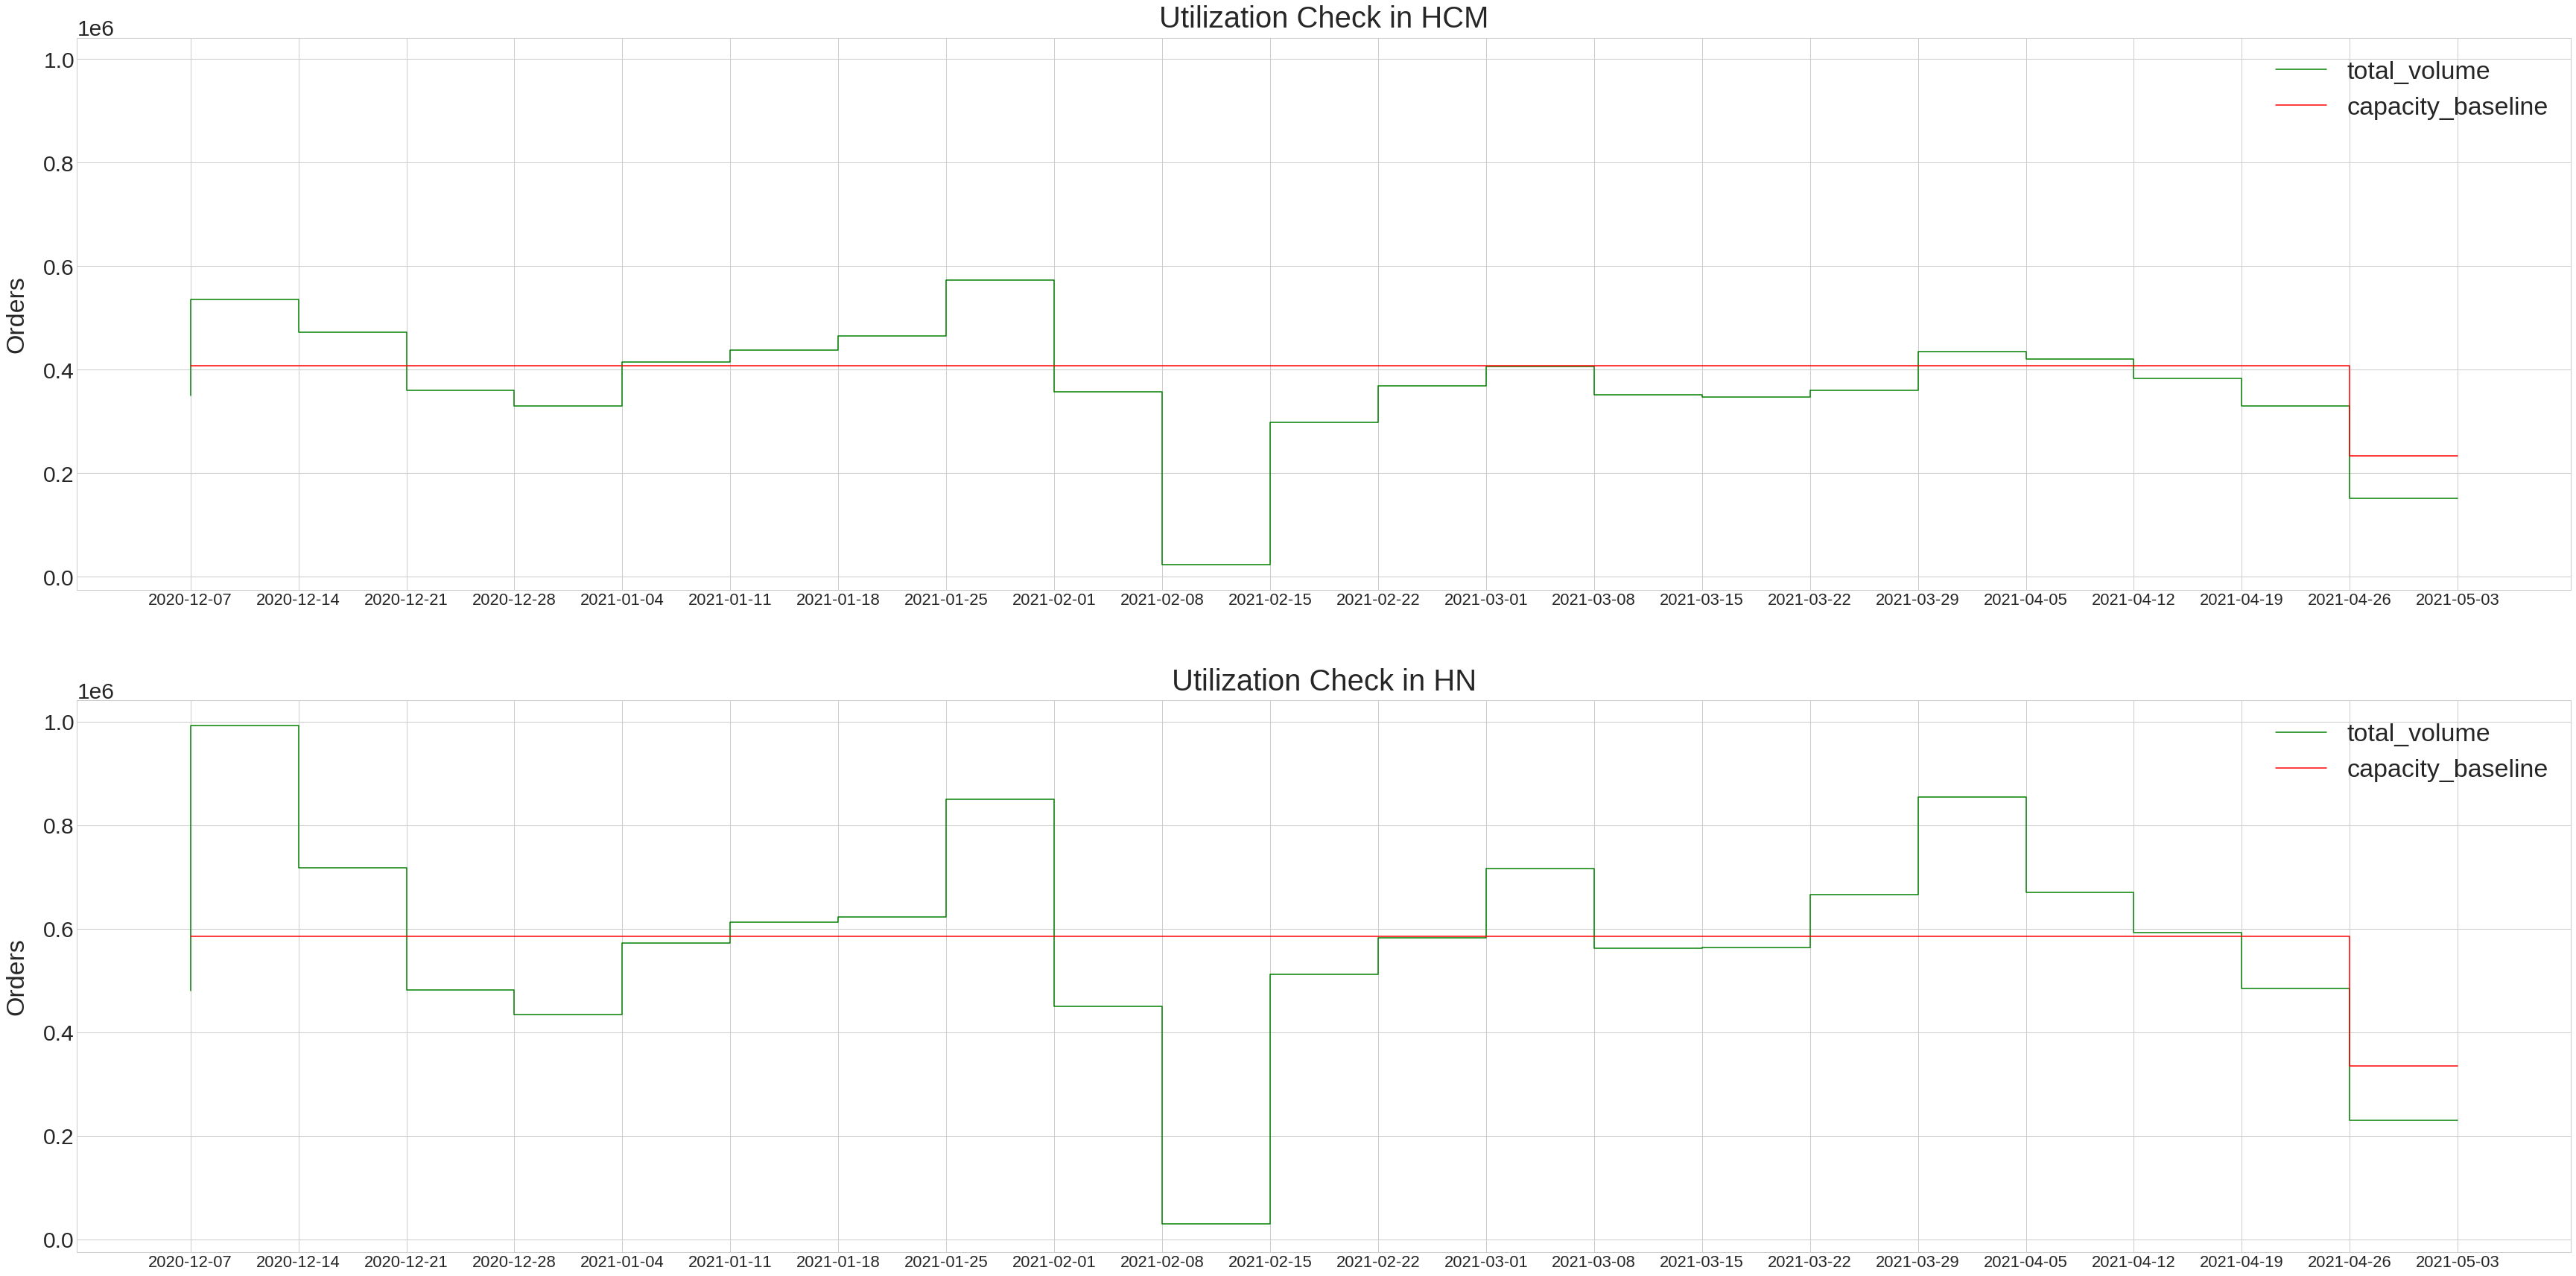

In [ ]:
plt.style.use('seaborn-whitegrid')
params = {'legend.fontsize': 34,
          'axes.labelsize': 34,
          'axes.titlesize':40,
          'xtick.labelsize':22,
          'ytick.labelsize':30,
          'axes.titlepad':14.0,
          'axes.labelpad':20.0,
          'figure.subplot.hspace': 0.2,
        }
pylab.rcParams.update(params)
fig, ax3 = plt.subplots(2, 1, figsize=(60,30),squeeze=False,sharey=True)
hub_region=['HCM','HN']
ax3=ax3.ravel()
for j,i in enumerate(hub_region):
  ax3[j].plot(util_cal[util_cal['hub_region']==i]['cal_date'],util_cal[util_cal['hub_region']==i]['total_volume'],label='total_volume',ls='solid',ds='steps',color='green')
  ax3[j].plot(util_cal[util_cal['hub_region']==i]['cal_date'],util_cal[util_cal['hub_region']==i]['projection'],label='capacity_baseline',ls='solid',ds='steps',color='red')
  ax3[j].legend(loc='best')
  ax3[j].set_title('Utilization Check in '+ i)
  ax3[j].set_ylabel('Orders')
  ax3[j].set_xticklabels(util_cal[(util_cal['hub_region']==i)]['cal_date'].unique())

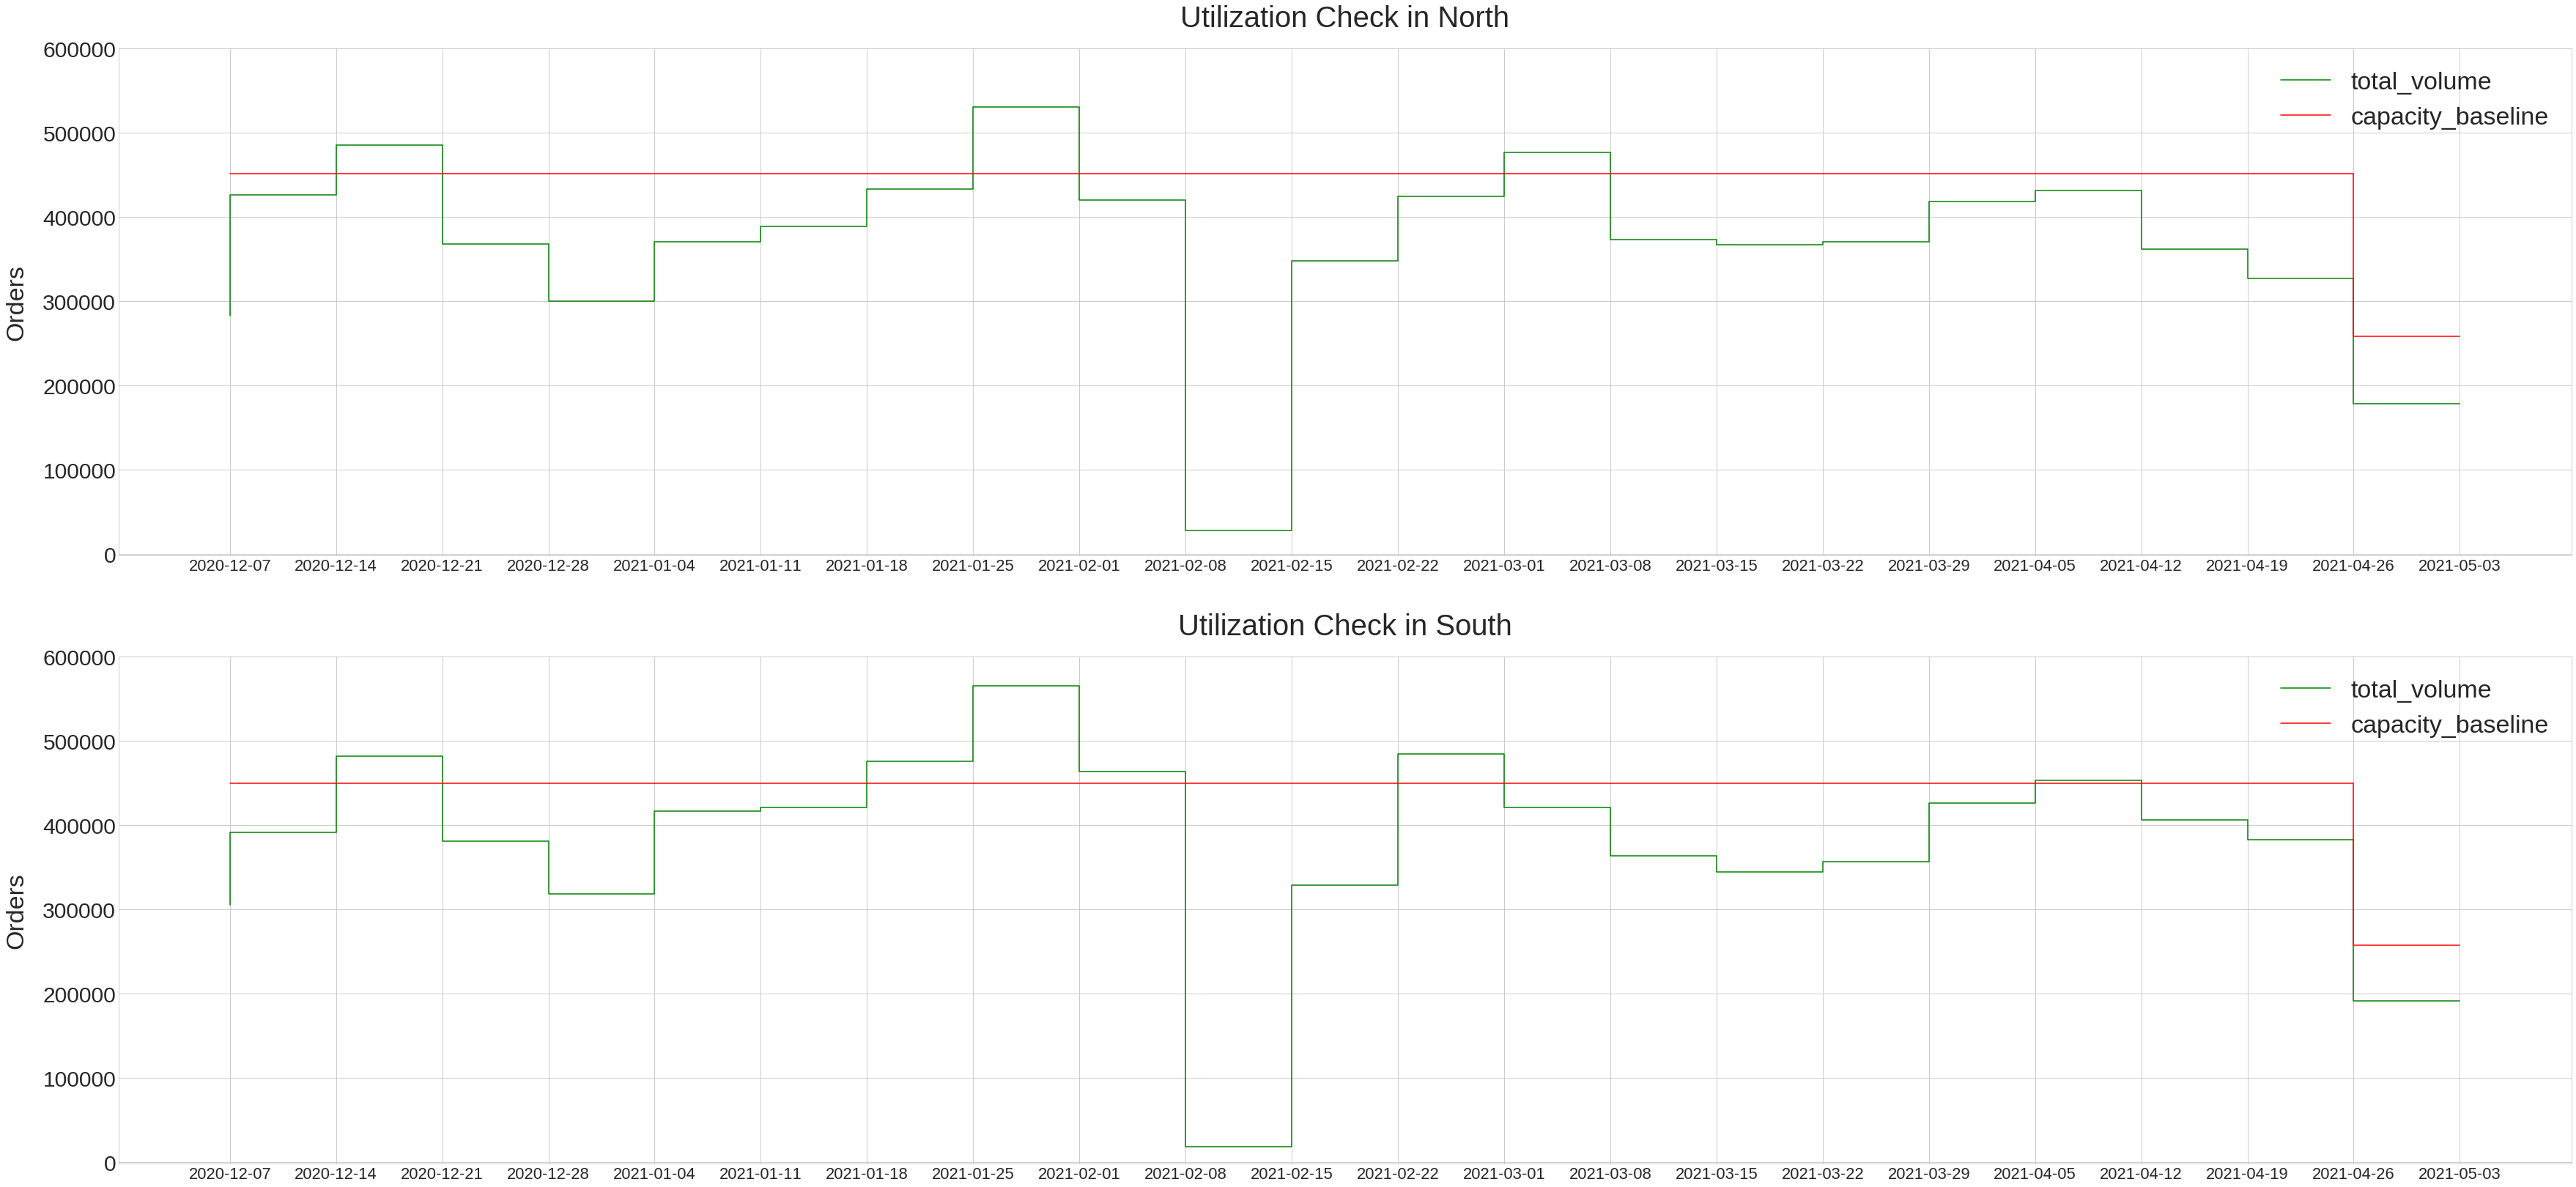

In [ ]:
plt.style.use('seaborn-whitegrid')
params = {'legend.fontsize': 34,
          'axes.labelsize': 34,
          'axes.titlesize':40,
          'xtick.labelsize':22,
          'ytick.labelsize':30,
          'axes.titlepad':30.0,
          'axes.labelpad':20.0,
          'figure.subplot.hspace': 0.2,
        }
pylab.rcParams.update(params)
fig, ax3 = plt.subplots(2, 1, figsize=(60,28),squeeze=False,sharey=True)
hub_region=['North','South']
ax3=ax3.ravel()
for j,i in enumerate(hub_region):
  ax3[j].plot(util_cal[util_cal['hub_region']==i]['cal_date'],util_cal[util_cal['hub_region']==i]['total_volume'],label='total_volume',ls='solid',ds='steps',color='green')
  ax3[j].plot(util_cal[util_cal['hub_region']==i]['cal_date'],util_cal[util_cal['hub_region']==i]['projection'],label='capacity_baseline',ls='solid',ds='steps',color='red')
  ax3[j].legend(loc='best')
  ax3[j].set_title('Utilization Check in '+ i)
  ax3[j].set_ylabel('Orders')
  ax3[j].set_xticklabels(util_cal[(util_cal['hub_region']==i)]['cal_date'].unique())
  ax3[j].set_ylim(ymin=-2000, ymax=round(util_cal[util_cal['hub_region']==i]['total_volume'].max(),-5))

Text(0.5, 1.0, 'hub_region')

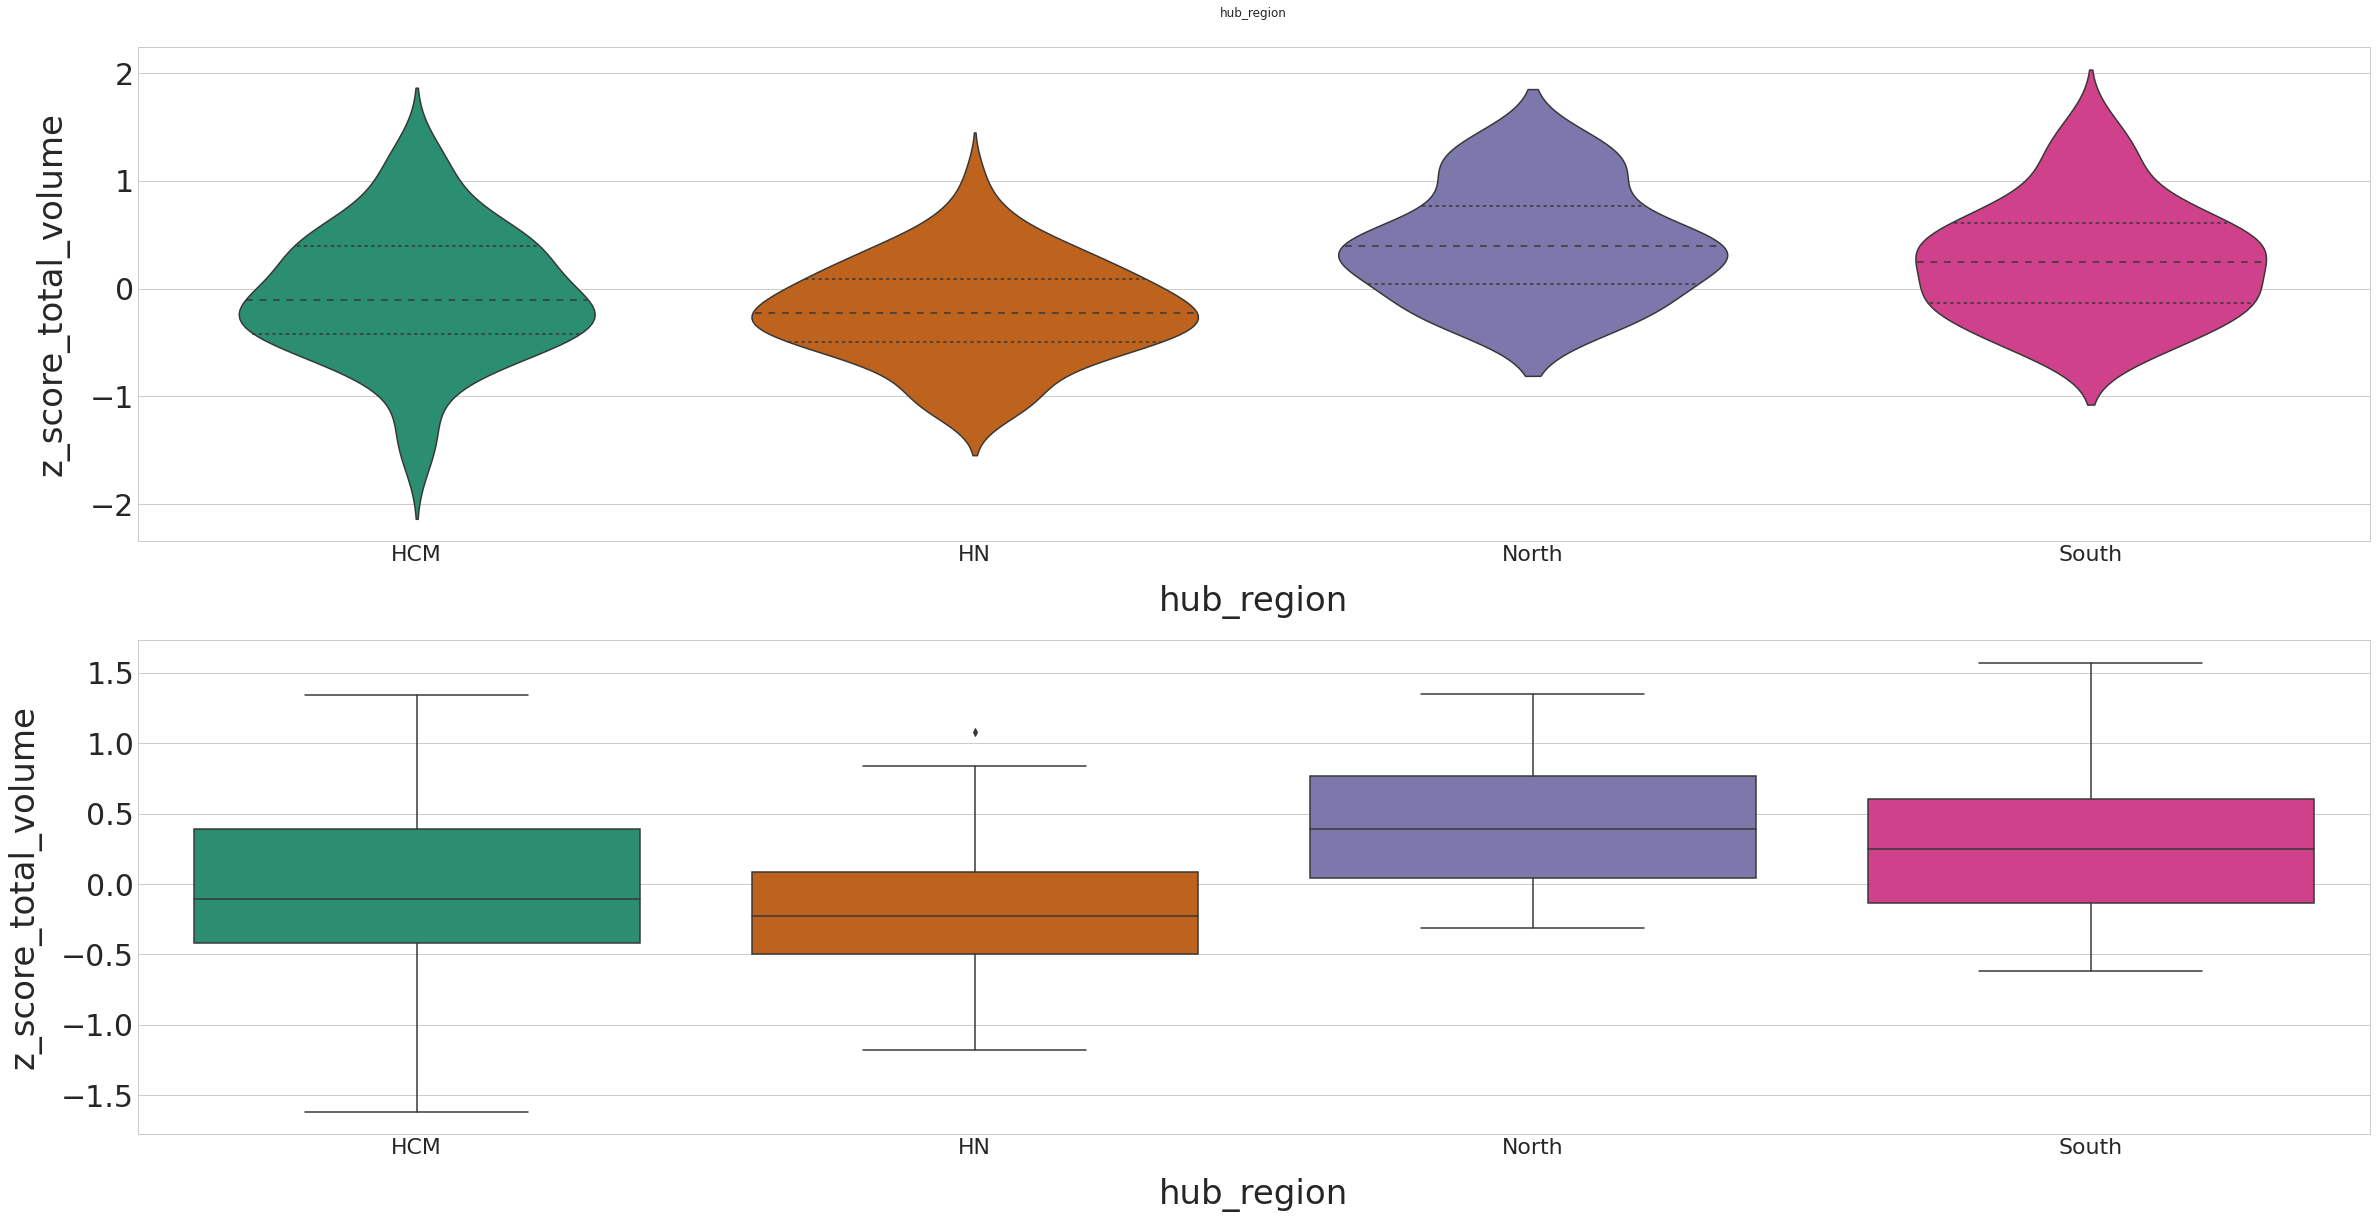

In [ ]:
fig, ax4 = plt.subplots(2,1,figsize=(40,20),squeeze =False,)
sns.set_theme(style="whitegrid")
sns.violinplot(data=final,x='hub_region',y='z_score_total_volume',inner="quartile",ax=ax4[0,0],palette='Dark2')
sns.boxplot(data=final,x='hub_region',y='z_score_total_volume',ax=ax4[1,0],palette='Dark2')
# sns.boxplot(data=df3,x='target',y='hub_region',ax=ax1[0,2],palette='Dark2')
ax4[0,0].set_title('hub_region')

# Data Final

In [ ]:
final_result.to_csv('/content/drive/MyDrive/Capacity Project/Data Result/region_capacity.csv')
util_cal.to_csv('/content/drive/MyDrive/Capacity Project/Data Result/region_utilization.csv')

In [ ]:
# Calculation Utilization rate
volume_daily=final1[['cal_date','total_volume','hub_region']].groupby(['cal_date','hub_region']).agg({'total_volume':'sum','cal_date':pd.Series.nunique}).rename(columns={'cal_date': 'working_days'}).reset_index()
util_cal1=final_result.merge(volume_daily,how='inner',on='hub_region')
util_cal1['projection']=util_cal1.apply(lambda x: x.upper*x.working_days,axis=1)
util_cal1['util_rate']=util_cal1.apply(lambda x: (x.total_volume/(x.upper*x.working_days))*100.00,axis=1)
util_cal1['over_cap']=util_cal1.apply(lambda x: True if x.total_volume >= x.projection else False,axis=1)
util_cal1['under_cap']=util_cal1.apply(lambda x: True if x.total_volume < x.projection else False,axis=1)
util_cal1['range']=util_cal1.apply(lambda x: x.total_volume - x.projection,axis=1)
util_cal1=util_cal1.round({'rider_no':0,'mean':-2,'upper':-2,'lower':-2,'util_rate':2,'range':-1}).reset_index(drop=True)

In [ ]:
over_cap=util_cal1[util_cal1['over_cap']==True].groupby(['hub_region']).agg({'range':'mean'}).round(-2).reset_index()
over_cap['range'] = over_cap['range'].map('{:,.2f}'.format)
over_cap

,range
hub_region,
HCM,14900.0
HN,30600.0
North,10000.0
South,11700.0


In [ ]:
under_cap=util_cal1[util_cal1['under_cap']==True].groupby(['hub_region']).agg({'range':'mean'}).round(-2).reset_index()
under_cap['range'] = under_cap['range'].map('{:,.2f}'.format)
under_cap

,range
hub_region,
HCM,-16000.0
HN,-20800.0
North,-21300.0
South,-22800.0


In [ ]:
util_cal.groupby(['hub_region']).agg({'over_cap':'mean','under_cap':'mean'}).round(4)

,over_cap,under_cap
hub_region,,
HCM,0.3636,0.6364
HN,0.4545,0.5455
North,0.1364,0.8636
South,0.2727,0.7273
